### Building Atoms: direct definition

ASE is Python library for _atomistic modelling_; systems are fundamentally described by a set of atomic positions, and calculations are derived from these.

When working with ASE molecules and materials are represented by the `Atoms` class. We can define a molecule with lists of symbols and positions:

In [1]:
from ase import Atoms

d = 1.10
molecule = Atoms(['N', 'N'], positions=[(0., 0., 0.), (0., 0., d)])

or, conveniently, we can compress the positions to a chemical formula:

In [2]:
molecule = Atoms('N2', positions=[(0., 0., 0.), (0., 0., d)])

It can be useful to visualise our structure to make sure it is reasonable. `ase.visualize.view` provides a simple structure viewer in a floating window; this is quite useful when working on a Python script, but can be a little bit annoying when using a Jupyter notebook.

In [3]:
from ase.visualize import view
view(molecule)

<Popen: returncode: None args: ['/home/adam/.conda/envs/user-base/envs/ase-t...>

You can spin the molecule around with right-click-and-drag, and zoom with mouse wheel.

Some alternative viewers are available for Jupyter notebooks; here we will use `nglview`. It should be pre-installed on the virtual machines for the workshop. In this viewer left-click-and-drag is used for rotation.

In [4]:
import nglview
nglview.show_ase(molecule)

NGLWidget()

Many interesting systems are crystals, described by atomic positions in a periodic unit cell. There are two relevant settings for an Atoms object: the unit cell itself and the _periodic boundary conditions_ (PBC).

In [5]:
a = 5.387
crystal = Atoms('Zn4S4',
                scaled_positions=[[0., 0., 0.],
                                  [0., 0.5, 0.5],
                                  [0.5, 0., 0.5],
                                  [0.5, 0.5, 0.],
                                  [0.25, 0.75, 0.75],
                                  [0.25, 0.25, 0.25],
                                  [0.75, 0.75, 0.25],
                                  [0.75, 0.25, 0.75]],
               cell=[a, a, a],
               pbc=True)

def show(atoms: Atoms) -> None:    
    view = nglview.show_ase(atoms)
    if any(atoms.pbc):
        view.add_unitcell()
    return view

show(crystal)

NGLWidget()

We used a few tricks to make writing in the structure a bit easier:
- The symbols were compressed to 'Zn4S4'
- Instead of working out positions in Angstrom, `scaled_positions` relative to lattice vectors were used
- The cell with just 3 values, so it is assumed to be cubic. In other cases we might use the full 3x3 matrix, e.g. `cell=[[a, 0, 0], [0, a, 0], [0, 0, a]]`
- We set `pbc=True` to indicate periodic boundary conditions in all directions. These can also be specified along each direction, e.g. `pbc=[True, True, False]` for a "slab" calculation with exposed surfaces.

We also defined a Python function `show()` which will show Atoms including a unit cell with nglview. This will save us from writing three lines of code every time!

### Examining atoms: properties and methods

Now that we have some Atoms objects we can see what information is available from them. We call some "getter" methods on the `molecule` object, which is an instance of `Atoms`.

In [6]:
print("N2 positions")
print(molecule.get_positions(), end="\n\n")

print("N2 symbols")
print(molecule.get_chemical_symbols(), end="\n\n")

print("N2 masses")
print(molecule.get_masses(), end="\n\n")

print("N2 center of mass")
print(molecule.get_center_of_mass())

N2 positions
[[0.  0.  0. ]
 [0.  0.  1.1]]

N2 symbols
['N', 'N']

N2 masses
[14.007 14.007]

N2 center of mass
[0.   0.   0.55]


The first two attributes here are not surprising; they are the information we provided. The masses were not provided: when the Atoms was created, ASE found some standard values and included them in the data set.

If we like, we can override this default and include some isotopic effects:

In [7]:
d = 1.10
isotope = Atoms('N2',
                positions=[(0., 0., 0.), (0., 0., d)],
                masses=[13.006, 14.003])

print("13N-14N masses")
print(isotope.get_masses(), end="\n\n")

print("13N-14N center of mass")
print(isotope.get_center_of_mass())


13N-14N masses
[13.006 14.003]

13N-14N center of mass
[0.         0.         0.57030249]


The center of mass was _not_ defined when the Atoms are created; it is derived from the other properties. So if we modify the masses using a _setter_, it should be recalculated correctly.

In [8]:
isotope = molecule.copy()
print("Center of mass before modifying masses:")
print(isotope.get_center_of_mass(), end='\n\n')

isotope.set_masses([13.006, 14.003])
print("Center of mass after modifying masses:")
print(isotope.get_center_of_mass())

Center of mass before modifying masses:
[0.   0.   0.55]

Center of mass after modifying masses:
[0.         0.         0.57030249]


In a jupyter notebook we can get the "docstring" of a method or function by adding `?` to the name:

In [9]:
isotope.get_center_of_mass?

Signature: isotope.get_center_of_mass(scaled=False)
Docstring:
Get the center of mass.

If scaled=True the center of mass in scaled coordinates
is returned.
File:      ~/src/ase/ase/atoms.py
Type:      method

And we can get access to the available methods and properties with tab-completion. In a Jupyter notebook or IPython terminal, try:

```crystal.[TAB]```

where `[TAB]` means "hit the TAB key". You should see that the Atoms object has a lot of features available!

Not all of them ll work until we start using *Calculators*, but the rest of this tutorial should include some useful ones.

#### Exercise 1:
Use tab-completion and docstrings to explore the features of Atoms. In the ZnS structure, find the distance between the first Zn atom and the four S atoms. Are some of them nearer than others?

*Hint: you may need to use the "minimum image convention"*

## Reading and writing

Even with the shortcuts above, writing out structures in Python syntax can be a bit cumbersome. There are many established file formats for this data, and ASE contains read/write functions for some of them.

For example, we might obtain a structure from an online database. Here is the [Materials Project entry for sphalerite](https://materialsproject.org/materials/mp-10695); use the "export as" button on the structure visualiser to obtain a .cif file.

In [10]:
import ase.io
from pathlib import Path

# You may need to change the path to match the location/file you downloaded
imported_crystal = ase.io.read(Path.home() / "Downloads/ZnS.cif", format='cif')

show(imported_crystal)

NGLWidget()

Using the virtual desktop, have a look at this .cif file in a text editor. CIF is quite a complicated format because it is designed to hold a lot of data relevant to crystallography. By comparison, the `FHI-aims` quantum chemistry code has a very simple structure format. Let's write the ZnS structure in this format instead:

In [11]:
ase.io.write('geometry.in', imported_crystal, scaled=True)

Taking a peek at this file:

In [12]:
%%bash
cat geometry.in

#===============================================================================
# Created using the Atomic Simulation Environment (ASE)

# Mon Apr  3 11:11:50 2023

#=======================================================
lattice_vector 5.3873657499999998 0.0000000000000000 0.0000000000000000 
lattice_vector 0.0000000000000000 5.3873657499999998 0.0000000000000000 
lattice_vector 0.0000000000000000 0.0000000000000000 5.3873657499999998 
atom_frac 0.0000000000000000 0.0000000000000000 0.0000000000000000 Zn
atom_frac 0.5000000000000000 0.5000000000000000 0.0000000000000000 Zn
atom_frac 0.5000000000000000 0.0000000000000000 0.5000000000000000 Zn
atom_frac 0.0000000000000000 0.5000000000000000 0.5000000000000000 Zn
atom_frac 0.2500000000000000 0.2500000000000000 0.2500000000000000 S
atom_frac 0.2500000000000000 0.7500000000000000 0.7500000000000000 S
atom_frac 0.7500000000000000 0.7500000000000000 0.2500000000000000 S
atom_frac 0.7500000000000000 0.2500000000000000 0.7500000000000000 S


Note that
- we didn't specify the FHI-aims format; it was correctly guessed from the filename. (This also works for ase.io.read.)
- we added a `scaled=True` option to write in fractional coordinates; by default this writer uses Cartesian coordinates.

How does this work? There are lots of relevant functions in modules under `ase.io`: `ase.io.read()` and `ase.io.write()` will automatically dispatch to these functions. If we look at `ase.io.write?` we get the signature

```python
ase.io.write(
    filename: Union[str, pathlib.PurePath, IO],
    images: Union[ase.atoms.Atoms, Sequence[ase.atoms.Atoms]],
    format: str = None,
    parallel: bool = True,
    append: bool = False,
    **kwargs: Any,
) -> None
```

`**kwargs` means "all remaining keyword arguments"; this allows extra options like `scaled=True` to be passed to writers that understand them.

More information about the supported formats can be found at https://wiki.fysik.dtu.dk/ase/ase/io/io.html and a summary can be produced from the command-line with

In [13]:
%%bash
ase info --formats

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf
usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,nomad-upload,nomad-get,convert,reciprocal,completion,diff,exec}
           ...
ase: error: UnknownFileTypeError: File format not recognized: castep-castep.  Error: numpy.core.multiarray failed to import
To get a full traceback, use: ase -T info ...


platform                 Linux-6.2.7-200.fc37.x86_64-x86_64-with-glibc2.36
python-3.11.2            /usr/bin/python3
ase-3.23.0b1-cec70c9181  /home/adam/src/ase/ase
numpy-1.22.0             /usr/lib64/python3.11/site-packages/numpy
scipy-1.10.1             /home/adam/.local/lib/python3.11/site-packages/scipy
matplotlib               not installed
spglib                   not installed
ase_ext                  not installed
flask                    not installed
psycopg2                 not installed
pyamg                    not installed

Supported formats:
  abinit-in [rw/single]: ABINIT input file
  abinit-out [r/single]: ABINIT output file
  acemolecule-input [r/single]: ACE input file
  acemolecule-out [r/single]: ACE output file
  aims [rw/single, ext=in]: FHI-aims geometry file
  aims-output [r/multi]: FHI-aims output
  bundletrajectory [rw/multi]: ASE bundle trajectory


CalledProcessError: Command 'b'ase info --formats\n'' returned non-zero exit status 2.

To find the extra supported `**kwargs`, look at the documentation of the lower-level functions. For example we can find the `scaled=True` option for FHI-aims at https://wiki.fysik.dtu.dk/ase/ase/io/formatoptions.html#ase.io.aims.write_aims

#### Exercise 2
Import a structure file relevant to your own research, and write it to a different format. See what keywords are available for your favourite formats; for example, VASP users are likely to be interested in using  `vasp5=True`.

### Building Atoms: more tools

The `ase.build` module [(docs)](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) contains tools for building structures using parameters rather than detailed lists of positions.

#### Molecules
Definitions for a set of simple molecules (the "G2" set, plus a few extra) are included with ASE. So in fact the easiest way to get an N2 molecule is

In [14]:
import ase.build
g2_n2 = ase.build.molecule('N2')
show(g2_n2)

NGLWidget()

And it's just as easy to get a buckyball! This feature is very useful for testing and trying things out.

In [15]:
show(ase.build.molecule('C60'))

NGLWidget()

#### Crystals

The equivalent tool for crystals is `ase.build.bulk`. This includes lattice parameters for some elemental reference states (the list is [in the code here](https://gitlab.com/ase/ase/-/blob/6ac638d0c699f7bc80c10a8dccb7d42eda011be2/ase/data/__init__.py#L578)),
but we can also use known lattice parameters to build structures. So we get copper "for free":

In [16]:
show(ase.build.bulk('Cu', cubic=True))

NGLWidget()

but for ZnS we have to provide a bit more information:

In [17]:
show(
    ase.build.bulk('ZnS',
                   crystalstructure='zincblende',
                   a=5.387,
                   cubic=True)
)

NGLWidget()

### Supercells

A compact notation can be used to create a repeated unit cell. Starting with a cubic unit cell of Si:

In [18]:
si = ase.build.bulk('Si', cubic=True)
show(si)

NGLWidget()

equal repetition in each direction is possible with an integer multiplication:

In [21]:
show(si * 4)

NGLWidget()

A 3-list or 3-tuple gives the expansion in each direction:

In [22]:
show(si * [2, 4, 1])

NGLWidget()

For more complex transformations, we need to pass a 3x3 matrix to `ase.build.make_supercell`. I f we start with the non-cubic _primitive_ cell

In [23]:
si_prim = ase.build.bulk('Si')
show(si_prim)

NGLWidget()

cubic supercells can be formed with the correct transformation matrix.

In [24]:
si_prim.cell

Cell([[0.0, 2.715, 2.715], [2.715, 0.0, 2.715], [2.715, 2.715, 0.0]])

In [25]:
show(
    ase.build.make_supercell(si_prim, [[1, 1, -1], [1, -1, 1], [-1, 1, 1]])
)

NGLWidget()

How do we find such matrices? This case is a known "textbook" example, but we can also perform a numerical search to find the matrix giving the most cubic result. This can be useful when setting up supercell calculations to model dilute defects and maximise the distance between periodic images.

In [26]:
ase.build.find_optimal_cell_shape(si_prim.cell, 4, 'sc', verbose=True)

target metric (h_target):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
normalization factor (Q): 0.184162
idealized transformation matrix:
[[-1.  1.  1.]
 [ 1. -1.  1.]
 [ 1.  1. -1.]]
closest integer transformation matrix (P_0):
[[-1  1  1]
 [ 1 -1  1]
 [ 1  1 -1]]
smallest score (|Q P h_p - h_target|_2): 0.000000
optimal transformation matrix (P_opt):
[[-1  1  1]
 [ 1 -1  1]
 [ 1  1 -1]]
supercell metric:
[[5.43 0.   0.  ]
 [0.   5.43 0.  ]
 [0.   0.   5.43]]
determinant of optimal transformation matrix: 4


array([[-1,  1,  1],
       [ 1, -1,  1],
       [ 1,  1, -1]])

### Slicing and splicing

An Atoms object can be treated as a list of Atom objects, with numpy-like array slicing available.

In [30]:
for atom in crystal:
    print(atom.symbol, atom.position, atom.mass)

Zn [0. 0. 0.] 65.38
Zn [0.     2.6935 2.6935] 65.38
Zn [2.6935 0.     2.6935] 65.38
Zn [2.6935 2.6935 0.    ] 65.38
S [1.34675 4.04025 4.04025] 32.06
S [1.34675 1.34675 1.34675] 32.06
S [4.04025 4.04025 1.34675] 32.06
S [4.04025 1.34675 4.04025] 32.06


If we index multiple atoms, an Atoms object is returned:

In [31]:
zinc_indices = [i for i, atom in enumerate(crystal) if atom.symbol == 'Zn']
zinc_sublattice = crystal[zinc_indices]
show(zinc_sublattice)

NGLWidget()

Individual atoms can be appended:

In [32]:
from ase import Atom
composite = zinc_sublattice.copy()
composite.append(Atom('He', position=(1.34675, 4.04025, 4.04025)))
show(composite)

NGLWidget()

Or entire Atoms can be combined with `+`. (The first Atoms takes precedence to determine the cell etc.) So to obtain a distorted sphalerite cell, moving the S sublattice along the x coordinate relative to the Zn sublattice:

In [33]:
sulfur_sublattice = crystal[4:]
sulfur_sublattice.translate([.3, 0., 0.])
show(zinc_sublattice + sulfur_sublattice)

NGLWidget()

While Atoms is not exactly a regular Python object, it plays nicely with the delete operation. So to create a zinc-vacancy defect:

In [34]:
zinc_vacancy = crystal.copy()
del zinc_vacancy[0]
show(zinc_vacancy)

NGLWidget()

and to create antisite disorder, we can swap two positions from the positions array.

In [35]:
antisite = crystal.copy()
antisite.positions[[0, 4]] = antisite.positions[[4, 0]]
show(antisite)

NGLWidget()

### Lists of Atoms

Some I/O formats support a sequence of atoms. This is particularly common for molecular dynamics or geometry optimisation calculation outputs, but they can also be useful to store training data for model-fitting or machine-learning.

For example to create a set of similar structures with small displacements:

In [44]:
atoms = ase.build.bulk('Cu', cubic=True) * 2

atoms_sequence = []
for frame in range(10):
    atoms.rattle(stdev=0.02)  # rattle modifies the atoms in-place
    atoms_sequence.append(atoms.copy())
    
ase.io.write('cu_rattle.xyz', atoms_sequence, format='extxyz')

**Question:** *in this example, why do we need to make a new copy of Atoms in each step of the loop?*

If we read such a file, by default `ase.io.read()` will only return the last frame:

In [40]:
atoms_frame = ase.io.read('cu_rattle.xyz')
show(atoms_frame)

NGLWidget()

Looking at the [documentation of this function](https://wiki.fysik.dtu.dk/ase/ase/io/io.html#ase.io.read), we see the `index` parameter selects which frames are read. To get all the frames we can set `index=':'`, or we can even slice to get e.g. every alternate frame.

In [41]:
atoms_alternating = ase.io.read('cu_rattle.xyz', index='::2')

The built-in ASE GUI has some basic features to animate a list of atoms. Try playing with the "movie" controls:

In [42]:
view(atoms_alternating)

<Popen: returncode: None args: ['/home/adam/.conda/envs/user-base/envs/ase-t...>

Some image formats are also supported by `ase.io.write`. To create an animated GIF:

/home/adam/src/ase/ase/visualize/plot.py:59: UserWarning: You passed in an explicit save_count=100 which is being ignored in favor of len(frames)=10.
  animation = FuncAnimation(fig, drawimage, frames=images,


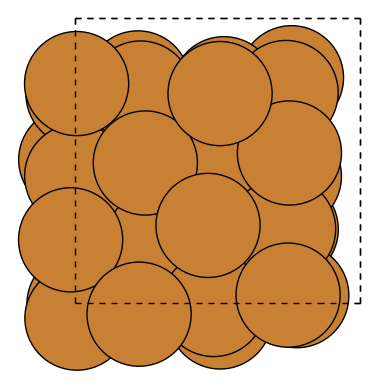

In [47]:
ase.io.write('rattle.gif', atoms_sequence)

## Final assignment

create this animation of a water molecule being wrapped in a C60 cage (or something even cooler!)

Hints:
- The GIF animation will need to be generated with a list of Atoms objects
- Molecules can be combined with +
- To get the wrapping effect we need to keep adding atoms that are near to the atoms already added
- To avoid writing too much repetitive code, use Python's looping tools

In [ ]:
water = ase.build.molecule('H2O')
water.center()

bucky = ase.build.molecule('C60')
bucky.center()


start_atom = 36
distances = bucky.get_all_distances()[start_atom]
sorted_bucky_indices = sorted(enumerate(distances),
                              key = (lambda x: x[1]))
sorted_bucky_indices = [i for i, _ in sorted_bucky_indices]
sorted_bucky = bucky[sorted_bucky_indices]

frames = [water.copy()]

for i in range(len(sorted_bucky)):
    frames.append(water + sorted_bucky[:i + 1])

from ase.io.animation import write_gif
_ = write_gif('wrapped_molecule.gif', frames)

![](wrapped_molecule.gif)